In [1]:
!pip install wget
!pip install nptdms

In [2]:
%load_ext autoreload
%autoreload 2

import das_package as dp
import os
import numpy as np
from tqdm import tqdm
import glob
from skimage.measure import block_reduce
import matplotlib.pyplot as plt
import scipy.signal as sp

c:\Users\alexa\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\alexa\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\Users\alexa\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,


# Downloading Raw Files (Download_data.ipynb)

In [3]:
interrogator = "Optasense"     #Optasense or Silixa
ship_number = 1
folder = f"Data/Raw/Ship{ship_number}"
results_folder = f"{folder}/results"
if not os.path.exists(results_folder):
    os.makedirs(results_folder)
url = "http://piweb.ooirsn.uw.edu/das/data/Optasense/SouthCable/TransmitFiber/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012014Z.h5"
first_file_time = dp.find_time_url(url, interrogator)
file_timing_length = 60
minutes = 5
n = int(minutes*60/file_timing_length)
all_filenames = dp.dl_das_files(folder, url, first_file_time, file_timing_length, n)
filenames = sorted([file for file in all_filenames if file != f"{folder}\\results"])
print(filenames)

Downloaded South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012014Z.h5
Downloaded South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012114Z.h5
Downloaded South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012214Z.h5
Downloaded South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012314Z.h5
Downloaded South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012414Z.h5
['Data/Raw/Ship1\\South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012014Z.h5', 'Data/Raw/Ship1\\South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012114Z.h5', 'Data/Raw/Ship1\\South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012214Z.h5', 'Data/Raw/Ship1\\South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012314Z.h5', 'Data/Raw/Ship1\\South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012414Z.h5']


# Loading Raw Data (Data_Cleaning.ipynb)

In [4]:
if interrogator == 'Optasense':
    rawData, dt, fs, dx, nx, ns, GL, sf, starting_time_timestamp = dp.optasense(filenames)

elif interrogator == 'Silixa':
    rawData, dt, fs, dx, nx, ns, GL, sf, starting_time_timestamp = dp.silixa(filenames)


# Downsample factors and channel chunking size
if fs == 1000:
    factor_channels = 2
    factor_time = 5
    ch_chunk_size = 500
elif fs == 500:
    factor_channels = 2
    factor_time = 2
    ch_chunk_size = 700
elif fs == 200:
    factor_channels = 2
    factor_time = 1
    ch_chunk_size = 1000

The concatenated data shape: (47500, 60000)
The first value in "RawDataTime" is 1635902414834000 which is the timestamp of the first sample in microseconds.
This equates to the date and time 2021-11-03 01:20:14.834000
the time step is equal to =  5000.0 microsecond

sampling rate in Hz =  200.0
channel spacing in m =  2.0419047
number of channels =  47500
number of samples in each channel =  60000
gauge length in m =  51.04762


# Converting Raw Data to AI-Ready Data (Prepare_AI_Ready_Data.ipynb)

In [5]:
distance = [50000, 55000]
if dx<2:
    chint = 1
elif dx>=2:
    chint = 1
duration = [0, int(ns/fs)]            #in second1
tint = 1                         #time interval (sample)


#Converting selected distance from meter to channels
channels = [int(distance[0]/dx), int(distance[1]/dx), chint]

#Finding number of itterations
itteration = (((channels[1] - channels[0]) / chint)//ch_chunk_size)
print('Number of itterations: ', itteration)


### Raw to strain rate ###
#Determine the first chunck of data
channels_chunk = [int(distance[0]/dx), min(int(distance[0]/dx) + ch_chunk_size*chint , int(distance[1]/dx)), chint]
time_chunk = [int(duration[0]*fs), int(duration[1]*fs), tint]

#Doing analysis for first chunk of data
trace, dist, time, starting_time_utc = dp.chunk_load(rawData, channels_chunk, time_chunk, dt, fs, dx, sf, starting_time_timestamp)
if interrogator == 'Optasense':
    str_rate = dp.strain2strainrate(trace, dt, tint)
elif interrogator == 'Silixa':
    str_rate = trace

#Doing analysis for remained chunks of data
for i in tqdm(range(int(itteration))):

    if (channels_chunk[1] + ch_chunk_size*chint)*dx >= distance[1]:
        channels_chunk = [channels_chunk[1], int(distance[1]/dx), chint]
    else:
        channels_chunk = [channels_chunk[1], channels_chunk[1] + ch_chunk_size*chint, chint]

    if channels_chunk[1] - channels_chunk[0] < 0.1*ch_chunk_size :
        break

    trace, dist_chunk, time, starting_time_utc = dp.chunk_load(rawData, channels_chunk, time_chunk, dt, fs, dx, sf, starting_time_timestamp)
    dist = np.concatenate([dist, dist_chunk])
    if interrogator == 'Optasense':
        str_rate_chunk = dp.strain2strainrate(trace, dt, tint)
    elif interrogator == 'Silixa':
        str_rate_chunk = trace
    str_rate = np.concatenate([str_rate, str_rate_chunk], axis=0)
    del str_rate_chunk, dist_chunk

np.save(f'{folder}/results/str_rate{ship_number}', str_rate)
np.save(f'{folder}/results/time{ship_number}', time)
np.save(f'{folder}/results/dist{ship_number}', dist)

del trace, rawData

if interrogator == 'Optasense':
    files = glob.glob(os.path.join(folder, '*.h5'))
    print(files)
    for file in files:
        os.remove(file)

elif interrogator == 'Silixa':
    files = glob.glob(os.path.join(folder, '*.tdms'))
    print(files)
    for file in files:
        os.remove(file)


Number of itterations:  2.0


100%|██████████| 2/2 [00:10<00:00,  5.21s/it]


['Data/Raw/Ship1\\South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012014Z.h5', 'Data/Raw/Ship1\\South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012114Z.h5', 'Data/Raw/Ship1\\South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012214Z.h5', 'Data/Raw/Ship1\\South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012314Z.h5', 'Data/Raw/Ship1\\South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012414Z.h5']


## Downsampling the Data (Dimensionality_Reduction.ipynb)

In [6]:
# Downsample the raw data
str_rate_downsampled = block_reduce(str_rate, block_size=(factor_channels, factor_time), func=np.mean)
# Downsample the distance and time domain data
dist_downsampled = block_reduce(dist, block_size=factor_channels, func=np.mean)
time_downsampled = block_reduce(time, block_size=factor_time, func=np.mean)

# Exploratory Data Analysis

## Visualization

<function matplotlib.pyplot.show(close=None, block=None)>

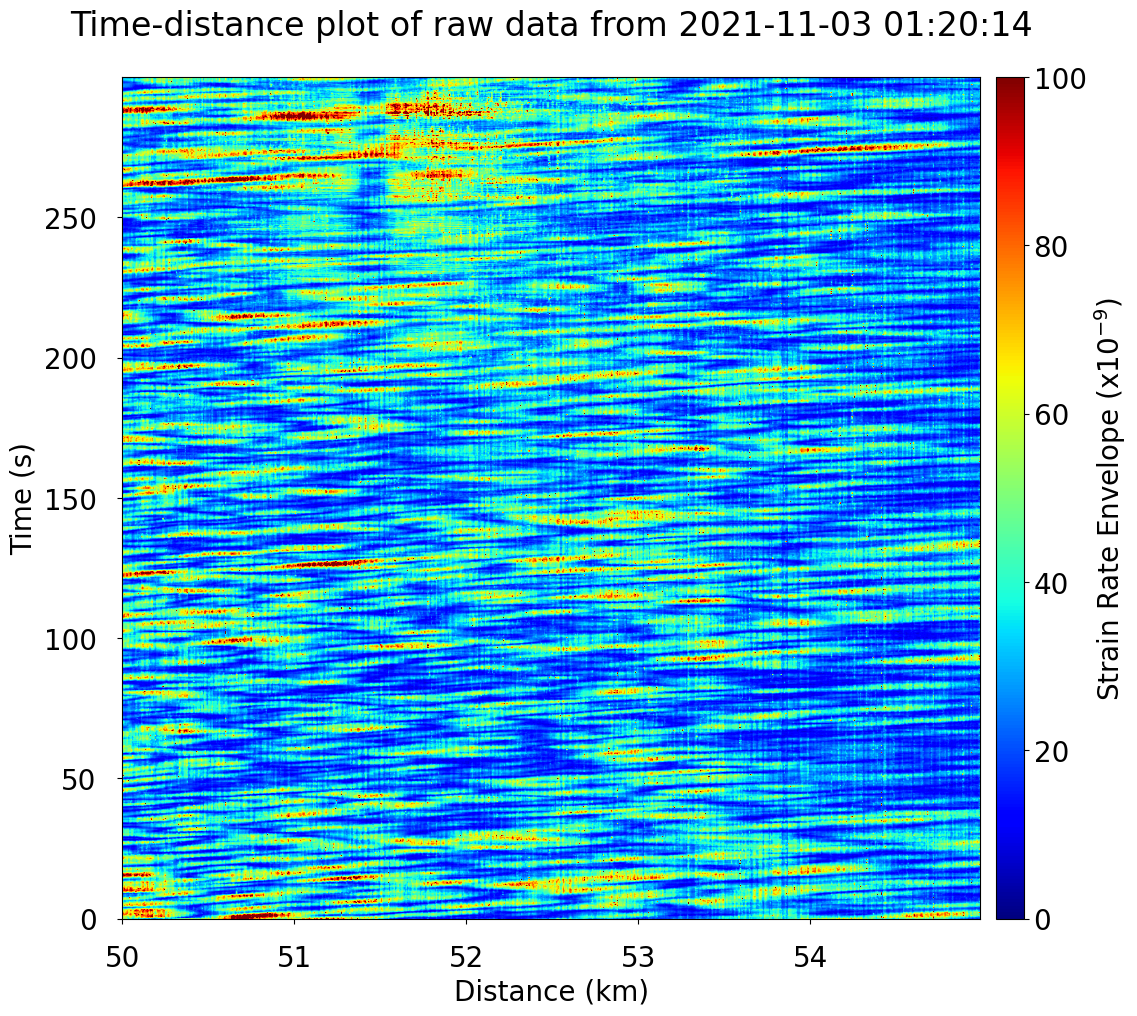

In [7]:
vmax = 100
dp.plot_tx(sp.hilbert(str_rate_downsampled[0:-2,:], axis=1), time_downsampled, dist_downsampled[0:-2], file_begin_time_utc=starting_time_utc, fig_size=(12, 10), v_min=0, v_max=vmax)
plt.title(f'Time-distance plot of raw data from {starting_time_utc.strftime("%Y-%m-%d %H:%M:%S")}', pad=30)
plt.show

## f-k plot

In [8]:
# Calculating FFT of the raw data
nnx, nns = str_rate.shape
fk_trace = np.fft.fftshift(np.fft.fft2(str_rate))
freq = np.fft.fftshift(np.fft.fftfreq(nns, d=1 / fs))
knum = np.fft.fftshift(np.fft.fftfreq(nnx, d=channels_chunk[2] * dx))

<function matplotlib.pyplot.show(close=None, block=None)>

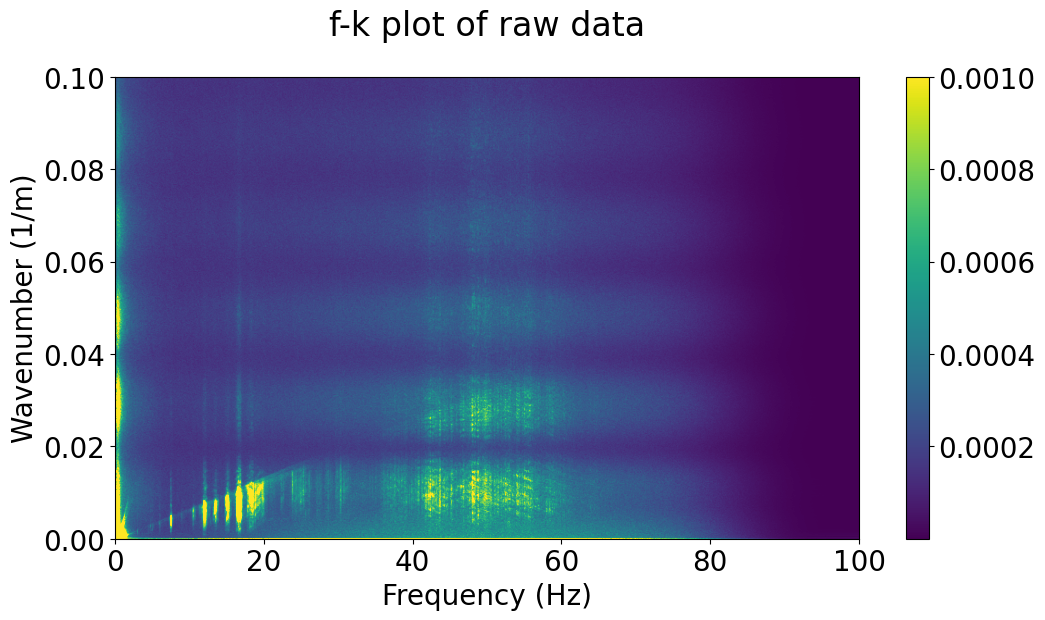

In [9]:
frq_max = 100
frq_min = 0
vmax = 0.001

# Plot the f-k spectrum
plt.figure(figsize=(12, 6))
shw = plt.imshow(np.abs(fk_trace), aspect='auto', extent=[freq[0], freq[-1], knum[0], knum[-1]], origin='lower', vmin=None, vmax=vmax)
plt.colorbar(shw)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Wavenumber (1/m)')
plt.xlim(frq_min, min(frq_max, fs/2))
plt.ylim(0, min(frq_max*0.001, 1/(2*dx)))
plt.title(f'f-k plot of raw data', pad=30)
plt.show

### Histograms and Mean, Max, Min, Variance

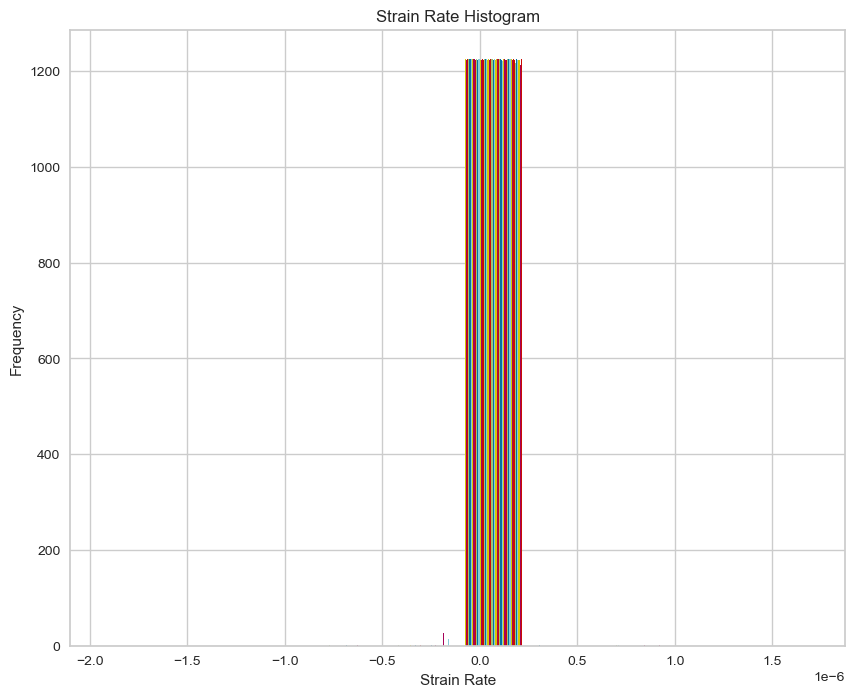

In [ ]:
#plotting downsampled strain rate - commented out because it takes a very long time to run
'''
plt.figure(figsize = (10,8))
plt.hist(str_rate_downsampled)
plt.title('Strain Rate Histogram')
plt.xlabel('Strain Rate')
plt.ylabel('Frequency')
plt.show()
'''




![Downsampled Strain Rate](.\MLGEO2024_DASclassification\notebooks\downsampled_str_rate_hist.png)


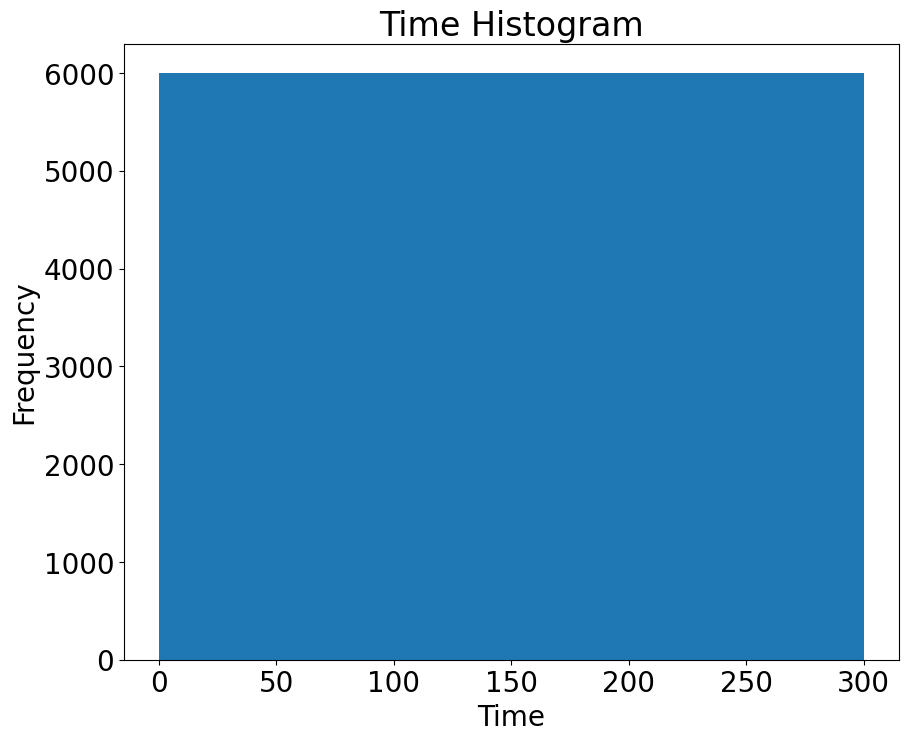

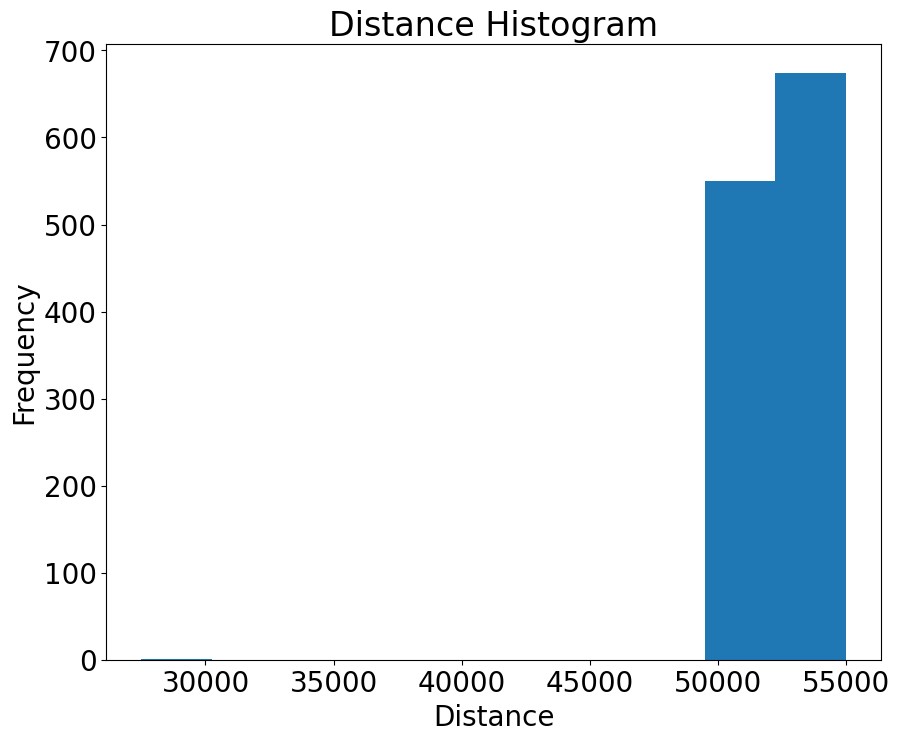

In [ ]:
#plotting downsampled time and distance in seperate cell b/c str rate takes long time
'''
plt.figure(figsize = (10,8))
plt.hist(time_downsampled)
plt.title('Time Histogram')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize = (10,8))
plt.hist(dist_downsampled)
plt.title('Distance Histogram')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.show()
'''

In [12]:
#finding stats of raw data
#Looking at mean, min, max, and variance in the raw vs. downsampled data

#loading raw data
str_rate1 = np.load('Data/Raw/Ship1/results/str_rate1.npy')
time1 = np.load('Data/Raw/Ship1/results/time1.npy')
distance1 = np.load('Data/Raw/Ship1/results/dist1.npy')

#finding stats of raw data

#strain rate
print('For the raw strain rate the mean is', np.mean(str_rate1), ', the min is', np.min(str_rate1), ', the max is', np.max(str_rate1), ', and the variance is', np.var(str_rate1))

#time
print('For the raw time the mean is', np.mean(time1), ', the min is', np.min(time1), ', the max is', np.max(time1), ', and the variance is', np.var(time1))

#distance
print('For the raw distance the mean is', np.mean(distance1), ', the min is', np.min(distance1), ', the max is', np.max(distance1), ', and the variance is', np.var(distance1))

#finding stats of the downsampled data
#strain rate
print('For the downsampled strain rate the mean is', np.mean(str_rate_downsampled), ', the min is', np.min(str_rate_downsampled), ', the max is', np.max(str_rate_downsampled), ', and the variance is', np.var(str_rate_downsampled))

#time
print('For the downsampled time the mean is', np.mean(time_downsampled), ', the min is', np.min(time_downsampled), ', the max is', np.max(time_downsampled), ', and the variance is', np.var(time_downsampled))

#distance
print('For the downsampled distance the mean is', np.mean(dist_downsampled), ', the min is', np.min(dist_downsampled), ', the max is', np.max(dist_downsampled), ', and the variance is', np.var(dist_downsampled))

For the raw strain rate the mean is 2.6912425977138103e-11 , the min is -3.299585434026353e-06 , the max is 3.4218971992660394e-06 , and the variance is 8.374479012263268e-16
For the raw time the mean is 149.9975 , the min is 0.0 , the max is 299.995 , and the variance is 7499.999997916667
For the raw distance the mean is 52497.36952543259 , the min is 49998.07818746567 , the max is 54996.660863399506 , and the variance is 2083853.5022452828
For the downsampled strain rate the mean is 2.6901441313474013e-11 , the min is -1.9571703155993153e-06 , the max is 1.7306528105730554e-06 , and the variance is 7.619358237691388e-16
For the downsampled time the mean is 149.9975 , the min is 0.0 , the max is 299.995 , and the variance is 7499.999997916667
For the downsampled distance the mean is 52475.9420276671 , the min is 27498.330431699753 , the max is 54993.59800636768 , and the variance is 2590158.0580004393


# Clustering Analysis for Classification Projects (Clustering_Analysis.ipnyb)


# AutoML and Hyperparamter Tuning (AutoML_Hyperparameter_Tuning.ipnyb)

### Making combined dataframe to input into the model

In [13]:
#make strain rate a pandas dataframe
import pandas as pd
df = pd.DataFrame(str_rate_downsampled)
df

#turn it into a 3d dataframe with time and distance
df = pd.DataFrame(str_rate_downsampled, index = dist_downsampled, columns = time_downsampled)

#add label to the distance and time
df.index.name = 'Distance'
df.columns.name = 'Time'

#find number of columns
num_columns = len(df.columns)
print(num_columns)


60000


### Making metadata dataframe for section where ship noise occurs.

In [14]:
#make a test metadata dataframe with the same distance index and time columns, but with the class label "ship" for points between distances 50500 and 52750 excluding times <200 
metadata = pd.DataFrame(index = df.index, columns = df.columns)
metadata = metadata.fillna(0)
metadata

Time,0.000,0.005,0.010,0.015,0.020,0.025,0.030,0.035,0.040,0.045,...,299.950,299.955,299.960,299.965,299.970,299.975,299.980,299.985,299.990,299.995
Distance,,,,,,,,,,,,,,,,,,,,,
49999.099140,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50003.182949,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50007.266759,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50011.350568,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50015.434377,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54981.346578,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
54985.430388,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
54989.514197,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# Find the closest index values for the given distances
start_distance = df.index.searchsorted(50500)
end_distance = df.index.searchsorted(52750)

print(start_distance)
print(end_distance)

# add ship label to the metadata for points in the specified distance and time range from above
metadata.iloc[start_distance:end_distance, 40000:-1] = 1


123
674


#### Plotting location

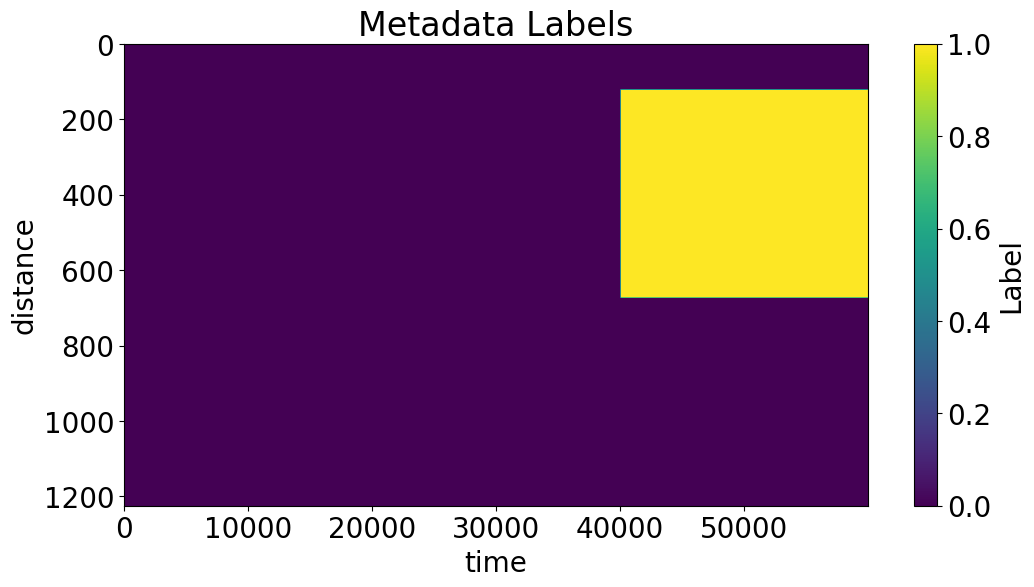

In [16]:
#plot the metadata to double check that the labels are correct and give values of 1 and 2 different colors
plt.figure(figsize=(12, 6))
plt.imshow(metadata, aspect='auto', cmap='viridis')
plt.colorbar(label='Label')
plt.title('Metadata Labels')
plt.xlabel('time')
plt.ylabel('distance')
plt.show()

location appears to be correct based on where the ship noise is located from Erfan's earlier exploration. 1 = ship, 0 = noise

In [17]:
!pip install pycaret[full]

In [18]:
#indexing the dataframe for 1000 time snippets that contain ship noise but keep all distances
df_small = df.iloc[:, 40000:41000]

#pull one column of metadata to use as the target from metadata_small
metadata_small = metadata.iloc[:, 40999:41000]

#rename 204.995 to class
metadata_small.columns = ['class']

#put class and distance on same index row
metadata_small = metadata_small.reset_index()


#add metadata_small to the df_small dataframe
df_small['class'] = metadata_small['class']

#replace NaN values with 0
df_small = df_small.fillna(0)

# Find the closest index values for the given distances within the subset
start_distance_small = df_small.index.searchsorted(50500)
end_distance_small = df_small.index.searchsorted(52750)

# Replace values in class column between distances 50500 and 52750 with 1
df_small.iloc[start_distance_small:end_distance_small, df_small.columns.get_loc('class')] = 1



C:\Users\alexa\AppData\Local\Temp\ipykernel_27464\2545755319.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small['class'] = metadata_small['class']


In [19]:
#import pycaret for classification
from pycaret.classification import *

classification = setup(df_small, target = "class")

best_classification = compare_models()

,Description,Value
0,Session id,4405
1,Target,class
2,Target type,Binary
3,Original data shape,"(1225, 1001)"
4,Transformed data shape,"(1225, 1001)"
5,Transformed train set shape,"(857, 1001)"
6,Transformed test set shape,"(368, 1001)"
7,Numeric features,1000
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9976,0.9999,0.9974,0.9974,0.9974,0.9952,0.9953,83.8730
knn,K Neighbors Classifier,0.9918,0.9998,0.9871,0.9949,0.9908,0.9835,0.9837,0.1090
et,Extra Trees Classifier,0.9907,0.9999,1.0000,0.9801,0.9898,0.9812,0.9816,0.1770
lightgbm,Light Gradient Boosting Machine,0.9895,0.9998,0.9897,0.9872,0.9883,0.9788,0.9790,2.8440
lda,Linear Discriminant Analysis,0.9149,0.9668,0.9094,0.9045,0.9060,0.8282,0.8296,0.2820
nb,Naive Bayes,0.8798,0.9212,0.9350,0.8246,0.8752,0.7603,0.7680,0.0900
qda,Quadratic Discriminant Analysis,0.6591,0.7007,0.5810,0.6297,0.6019,0.3053,0.3077,0.2500
ada,Ada Boost Classifier,0.5519,0.5023,0.0026,0.1000,0.0050,0.0028,0.0119,0.7650
gbc,Gradient Boosting Classifier,0.5519,0.5034,0.0026,0.1000,0.0050,0.0028,0.0119,3.5350
lr,Logistic Regression,0.5508,0.9334,0.0000,0.0000,0.0000,0.0000,0.0000,1.2220


In [20]:
#Print the best classification model to understand hyperparameters and other details
print(best_classification)

#also select lda because it was the best model in the previous run that did not overfit
best_lda = create_model('lda')


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9419,0.9808,0.9737,0.9024,0.9367,0.8831,0.8853
1,0.9419,0.9918,0.9211,0.9459,0.9333,0.8818,0.8820
2,0.9419,0.9782,0.9231,0.9474,0.9351,0.8824,0.8827
3,0.8372,0.9422,0.8205,0.8205,0.8205,0.6716,0.6716
4,0.9419,0.9798,0.8974,0.9722,0.9333,0.8819,0.8842
5,0.8605,0.9536,0.8974,0.8140,0.8537,0.7209,0.7241
6,0.9070,0.9836,0.8974,0.8974,0.8974,0.8123,0.8123
7,0.9294,0.9569,0.9737,0.8810,0.9250,0.8586,0.8625
8,0.9294,0.9457,0.9211,0.9211,0.9211,0.8572,0.8572


In [27]:
#select naive bayes since it is close to lda in performance
best_NB = create_model('nb')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8605,0.9090,0.9211,0.7955,0.8537,0.7217,0.7288
1,0.9070,0.9276,0.9737,0.8409,0.9024,0.8145,0.8225
2,0.8488,0.9040,0.8718,0.8095,0.8395,0.6970,0.6987
3,0.8953,0.9384,0.9744,0.8261,0.8941,0.7920,0.8026
4,0.8837,0.8958,1.0000,0.7959,0.8864,0.7704,0.7916
5,0.9186,0.9711,0.8974,0.9211,0.9091,0.8354,0.8357
6,0.8488,0.8996,0.9487,0.7708,0.8506,0.7009,0.7164
7,0.8706,0.9166,0.9211,0.8140,0.8642,0.7415,0.7467
8,0.8353,0.9040,0.8947,0.7727,0.8293,0.6718,0.6786


### Evaluate best_classification

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

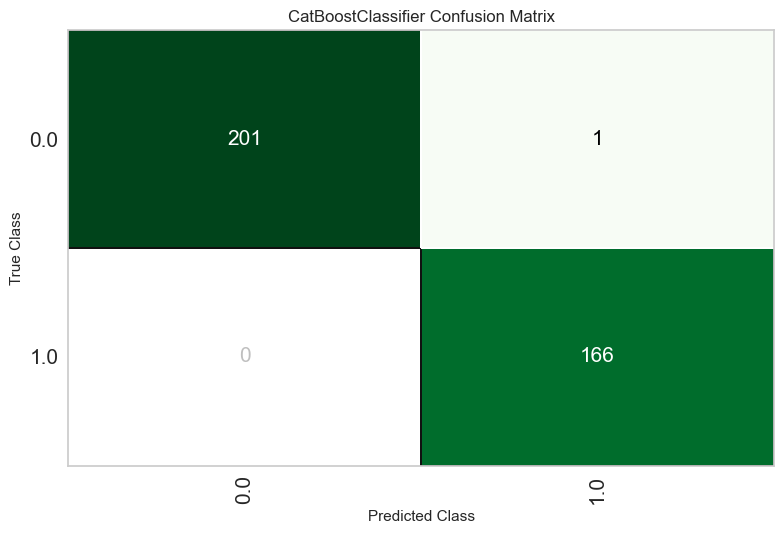

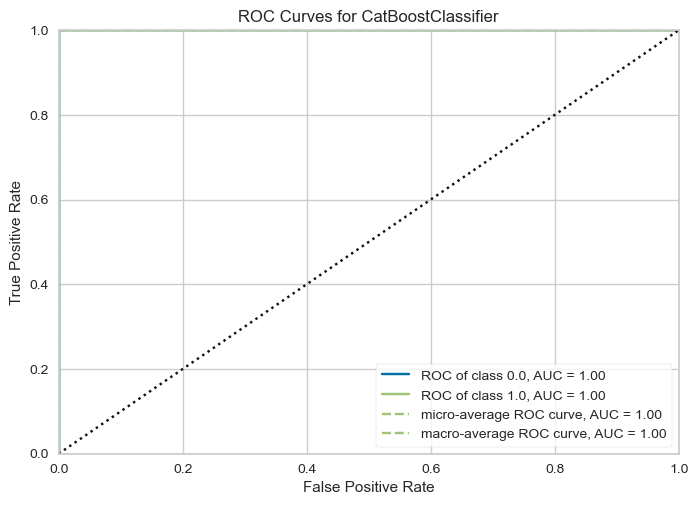

In [ ]:
#Analyze and evalute the model
evaluate_model(best_classification)

#plot confusion matrix
plot_model(best_classification, plot = 'confusion_matrix')

#plot roc curve
plot_model(best_classification, plot = 'auc')

In [22]:
#predict model
DASpredict = predict_model(best_classification, data=df_small, raw_score=True) 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.9992,1.0000,1.0000,0.9982,0.9991,0.9984,0.9984


In [23]:
#save model for later use
save_model(best_classification, 'best_classification_DAS')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['200.0', '200.005', '200.01',
                                              '200.015', '200.02', '200.025',
                                              '200.03', '200.035', '200.04',
                                              '200.045', '200.05', '200.055',
                                              '200.06', '200.065', '200.07',
                                              '200.075', '200.08', '200.085',
                                              '200.09', '200.095', '200.1',
                                              '200.105', '200.11', '200.115',
                                              '200.12', '200.125...
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                          

### Evaluate lda model

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

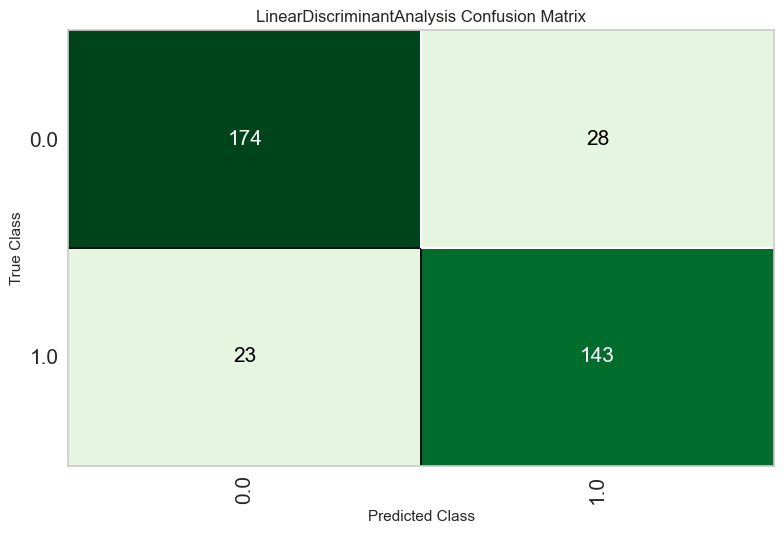

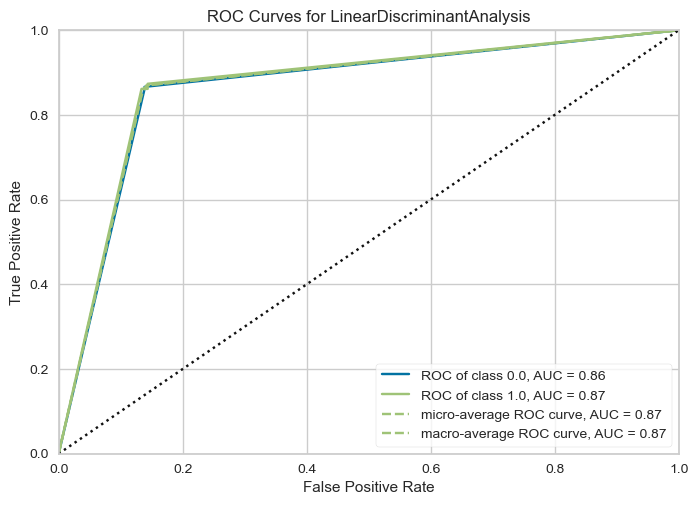

In [24]:
#Analyze and evalute the model
evaluate_model(best_lda)

#plot confusion matrix
plot_model(best_lda, plot = 'confusion_matrix')

#plot roc curve
plot_model(best_lda, plot = 'auc')

In [31]:
#predict model
DASpredict_lda = predict_model(best_lda, data=df_small, raw_score=True) 


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Linear Discriminant Analysis,0.9584,0.9608,0.9583,0.9496,0.9539,0.9160,0.9160


In [26]:
#save model for later use
save_model(best_lda, 'best_lda_DAS')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['200.0', '200.005', '200.01',
                                              '200.015', '200.02', '200.025',
                                              '200.03', '200.035', '200.04',
                                              '200.045', '200.05', '200.055',
                                              '200.06', '200.065', '200.07',
                                              '200.075', '200.08', '200.085',
                                              '200.09', '200.095', '200.1',
                                              '200.105', '200.11', '200.115',
                                              '200.12', '200.125...
                                                               missing_values=nan,
                                                               strategy='most_frequent'))),
         

### evaluate NB

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

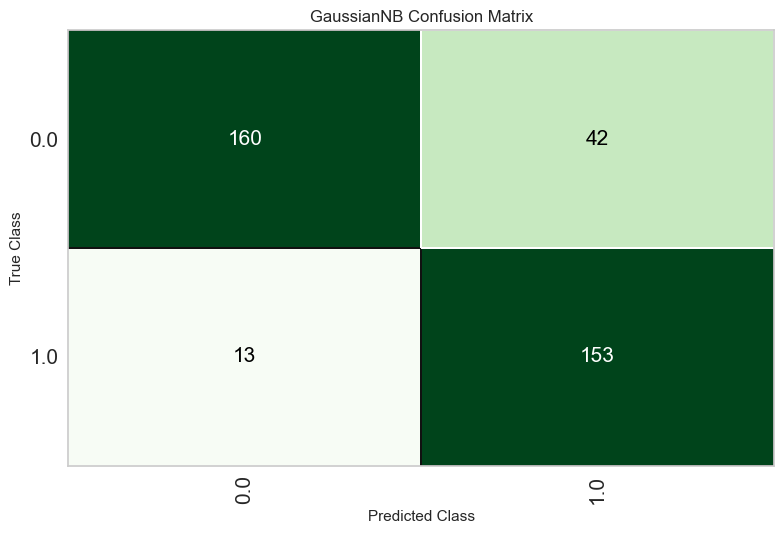

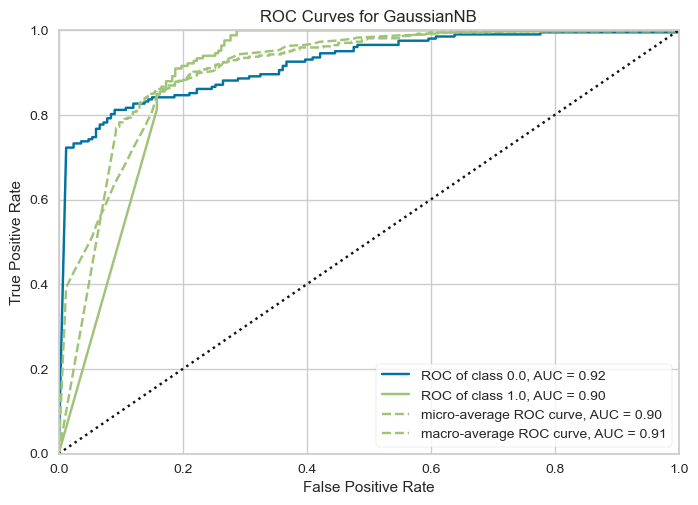

In [28]:
#Analyze and evalute the model
evaluate_model(best_NB)

#plot confusion matrix
plot_model(best_NB, plot = 'confusion_matrix')

#plot roc curve
plot_model(best_NB, plot = 'auc')

In [30]:
#predict model
DASpredict_NB = predict_model(best_NB, data=df_small, raw_score=True) 


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.8808,0.9212,0.9383,0.8219,0.8763,0.7623,0.7685


In [32]:
#save model for later use
save_model(best_NB, 'best_NB_DAS')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['200.0', '200.005', '200.01',
                                              '200.015', '200.02', '200.025',
                                              '200.03', '200.035', '200.04',
                                              '200.045', '200.05', '200.055',
                                              '200.06', '200.065', '200.07',
                                              '200.075', '200.08', '200.085',
                                              '200.09', '200.095', '200.1',
                                              '200.105', '200.11', '200.115',
                                              '200.12', '200.125...
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                          

### Description of algorithms evaluated + hyperparameters

### Most promising models

# Training Engineering and Model Assessment (Model_Training_Assessment.ipynb)

# Computational Time Analysis (Computational_Time_Analysis.ipynb)